# Почнемо наші екчперементи з графіку лосу для початкового коду

In [1]:
from pathlib import Path
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

Using device: cpu
# Params: 159010
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.321859
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.181064
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.212651
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.022429
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.043178
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.255571
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.033769
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.138570
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.105234
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.012995
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.030463
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.130743
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.015251
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.133727
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.111276
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.013575
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.021744
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.077513

Test set: Average loss: 0.0149, Accuracy: 9557/10000 (96%)



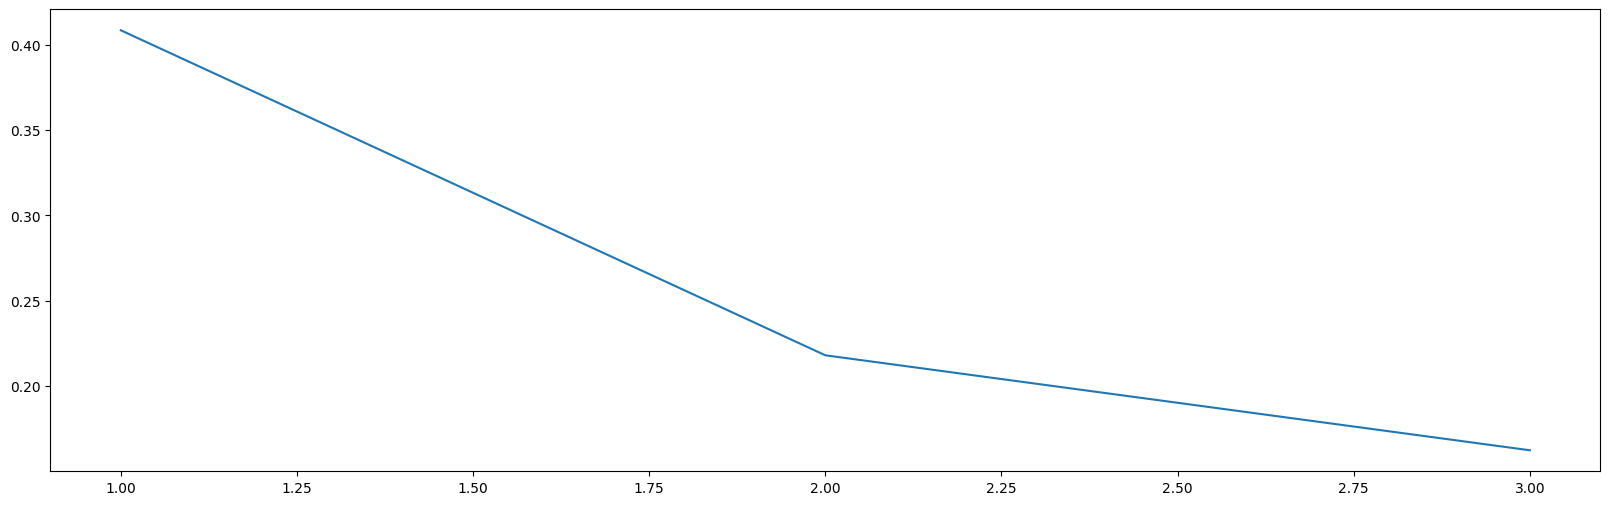

In [6]:
torch.manual_seed(1337)
        

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

        # number of nodes (neurons) in input, hidden, and output layer
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]


if __name__ == "__main__":

    total_losses = []
    
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 3

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        losses = []
        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        total_losses.append(sum(losses)/len(losses))
    
    ##### Testing! #####
    model.eval()
    test_loss = 0
    correct = 0
    with torch.inference_mode():
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            output = model(features)
            test_loss += criterion(output, target).item()  # sum up batch loss
            losses.append(criterion(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # torch.save(model.state_dict(), "mnist_001.pth")
    plt.figure(figsize=(20,6))
    plt.plot(range(1, epochs+1), total_losses)
    plt.savefig("loss.png")

# Переходимо до першого експеременту

Додаємо дропаут до нашого аутпуту

Using device: cpu
# Params: 159010
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.332539
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.317556
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.656733
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.175970
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.067940
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.396310
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.186812
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.113179
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.115872
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.011860
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.203048
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.289993
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.131856
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.160800
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.181996
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.013859
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.012311
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.233933

Test set: Average loss: 0.0144, Accuracy: 9559/10000 (96%)



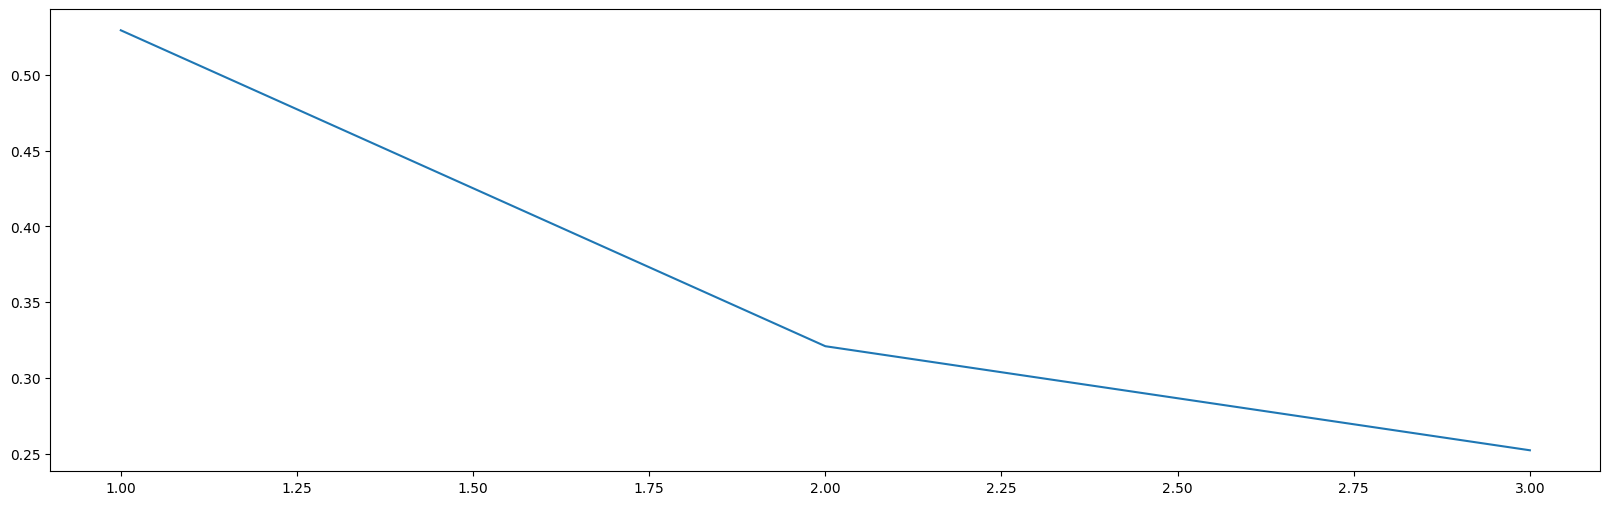

In [9]:
torch.manual_seed(1337)
        

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

        # number of nodes (neurons) in input, hidden, and output layer
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.drop = torch.nn.Dropout(p=0.1)
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.who(out)
        out = self.drop(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]


if __name__ == "__main__":

    total_losses = []
    
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 3

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        losses = []
        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        total_losses.append(sum(losses)/len(losses))
    ##### Testing! #####
    model.eval()
    test_loss = 0
    correct = 0
    with torch.inference_mode():
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            output = model(features)
            test_loss += criterion(output, target).item()  # sum up batch loss
            losses.append(criterion(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # torch.save(model.state_dict(), "mnist_001.pth")
    plt.figure(figsize=(20,6))
    plt.plot(range(1, epochs+1), total_losses)
    plt.savefig("first.png")

# Результат першого експеременту

Бачимо дуже маленьке покращення у лосі та кількості правильно класифікованних даних

Проте це покращення незначне і не має впливу на якість моделі

**Перейдемо до наступного експеременту**

Додаємо дропаут до хіден леєру

Додаємо ще слоїв до нашої моделі

Using device: cpu
# Params: 199210
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.323251
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.306638
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.316955
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.070383
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.863884
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.805481
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.746112
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.702799
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.731866
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.685106
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.710187
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.620565
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.585274
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.615872
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.607206
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.657998
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.663766
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.608527

Test set: Average loss: 0.1638, Accuracy: 6617/10000 (66%)



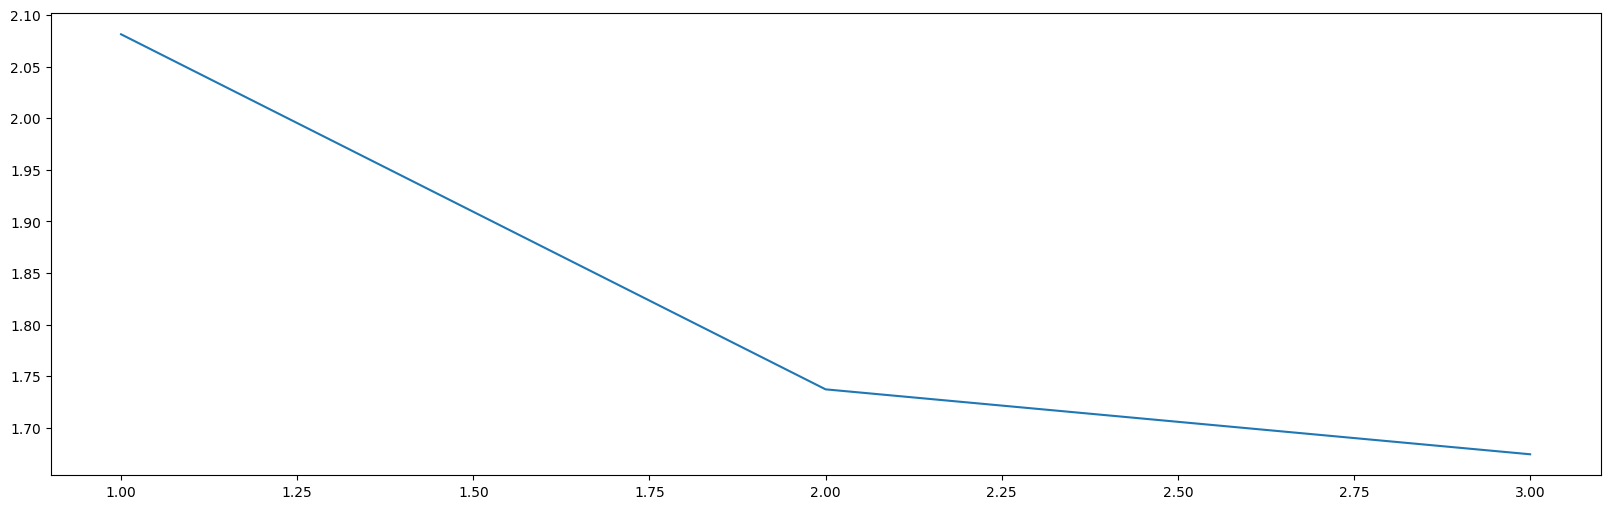

In [10]:
torch.manual_seed(1337)
        

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

        # number of nodes (neurons) in input, hidden, and output layer
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.drop = torch.nn.Dropout(p=0.2)
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=hiddennodes)
        self.layer3 = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.drop(out)
        out = self.who(out)
        out = self.activation(out)
        out = self.drop(out)
        out = self.layer3(out)
        out = self.activation(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]


if __name__ == "__main__":

    total_losses = []
    
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 3

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        losses = []
        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        total_losses.append(sum(losses)/len(losses))
    ##### Testing! #####
    model.eval()
    test_loss = 0
    correct = 0
    with torch.inference_mode():
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            output = model(features)
            test_loss += criterion(output, target).item()  # sum up batch loss
            losses.append(criterion(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # torch.save(model.state_dict(), "mnist_001.pth")
    plt.figure(figsize=(20,6))
    plt.plot(range(1, epochs+1), total_losses)
    plt.savefig("second.png")

# Результати другого експеременту

Як бачимо, третій слой тільки погіршив результати моделі. 

# Третій тест

Прибираємо третій слой моделі.

Нормалізуємо батчі

Using device: cpu
# Params: 159030
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.569782
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.245832
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.646556
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.119060
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.085586
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.384004
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.130423
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.339767
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.427908
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.066484
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.049459
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.115902
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.083400
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.100883
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.548524
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.158617
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.050247
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.409249

Test set: Average loss: 0.0137, Accuracy: 9597/10000 (96%)



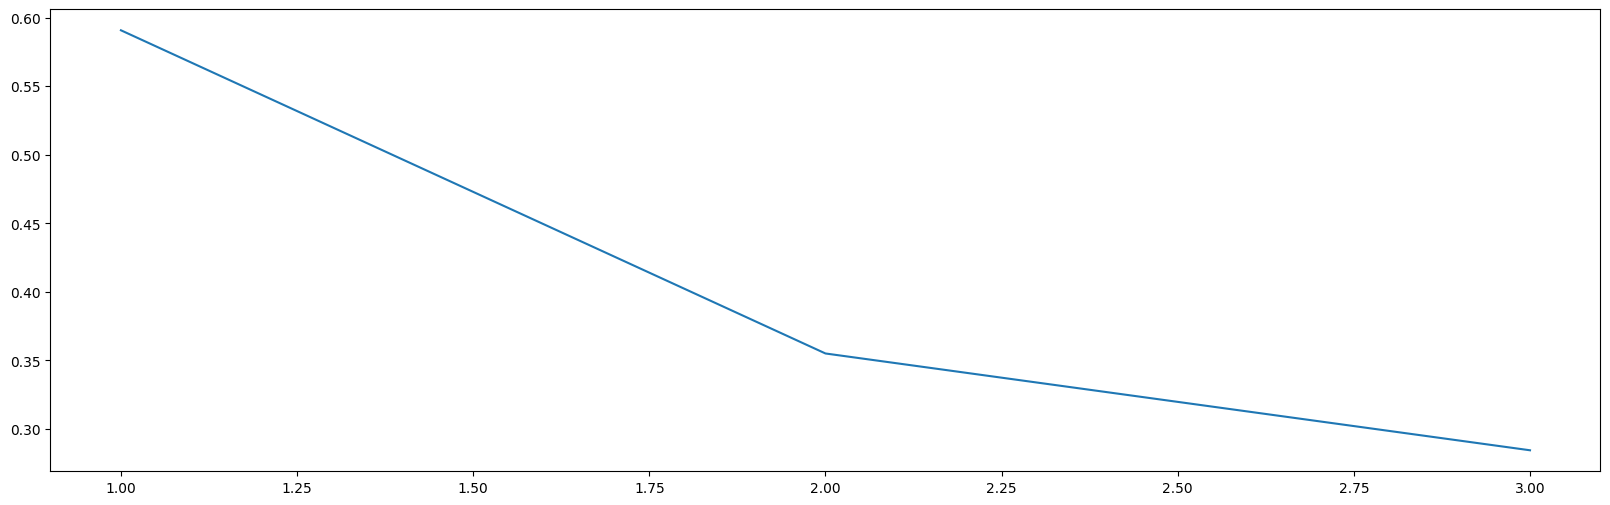

In [11]:
torch.manual_seed(1337)
        

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

        # number of nodes (neurons) in input, hidden, and output layer
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.drop = torch.nn.Dropout(p=0.2)
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()
        self.batchnorm = torch.nn.BatchNorm1d(outputnodes)

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.drop(out)
        out = self.who(out)
        out = self.activation(out)
        out = self.batchnorm(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]


if __name__ == "__main__":

    total_losses = []
    
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 3

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        losses = []
        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        total_losses.append(sum(losses)/len(losses))    
    ##### Testing! #####
    model.eval()
    test_loss = 0
    correct = 0
    with torch.inference_mode():
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            output = model(features)
            test_loss += criterion(output, target).item()  # sum up batch loss
            losses.append(criterion(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # torch.save(model.state_dict(), "mnist_001.pth")
    plt.figure(figsize=(20,6))
    plt.plot(range(1, epochs+1), total_losses)
    plt.savefig("third.png")

# Результат третього тесту

Нормалізація батчів покращила нашу модель.

Все ще в незначній кількості, але більш помітно аніж просто додання дропауту.

# Четвертий тест

Експерементуємо з нормалізацією та дропаутом, а також із функцією активації

Using device: cpu
# Params: 159430
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.710716
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.158127
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.653321
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.132598
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.160450
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.455109
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.103185
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.085149
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.458057
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.043674
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.057954
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.096547
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.072759
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.081190
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.546343
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.073830
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.062755
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.130067

Test set: Average loss: 0.0127, Accuracy: 9613/10000 (96%)



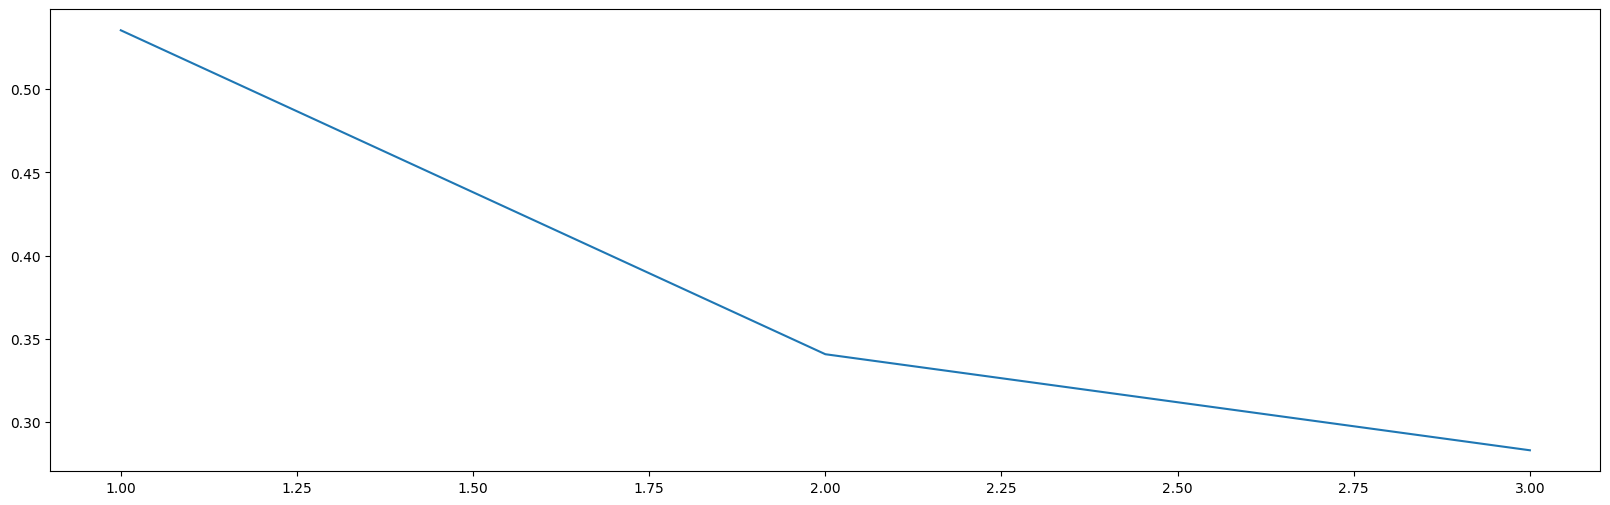

In [12]:
torch.manual_seed(1337)
        

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

        # number of nodes (neurons) in input, hidden, and output layer
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.drop = torch.nn.Dropout(p=0.2)
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.ELU()
        self.batchnorm = torch.nn.BatchNorm1d(hiddennodes)
        self.batchnorm2 = torch.nn.BatchNorm1d(outputnodes)

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.drop(out)
        out = self.batchnorm(out)
        out = self.who(out)
        out = self.activation(out)
        out = self.batchnorm2(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]


if __name__ == "__main__":

    total_losses = []
    
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 3

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        losses = []
        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        total_losses.append(sum(losses)/len(losses))
    ##### Testing! #####
    model.eval()
    test_loss = 0
    correct = 0
    with torch.inference_mode():
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            output = model(features)
            test_loss += criterion(output, target).item()  # sum up batch loss
            losses.append(criterion(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # torch.save(model.state_dict(), "mnist_001.pth")
    plt.figure(figsize=(20,6))
    plt.plot(range(1, epochs+1), total_losses)
    plt.savefig("fourth.png")

# Результат четвертого експеременту

- Оптимальна послідовність слою: активація, дропаут, батч нормалізація
- ELU найбільш підходить як функція активації
- Два слої достатньо

**Експеремент з розміром батчів, епох та льорнінг рейта**

Using device: cpu
# Params: 159430
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.769806
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.504073
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.369275
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.311089
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.246842
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.229171
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.208539
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.187716
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.173132
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.148074
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.131846
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.137059
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.129904
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.122702
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.106491
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.103112
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.085841
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.095565
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.079035
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.100360
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.087497
Train Epo

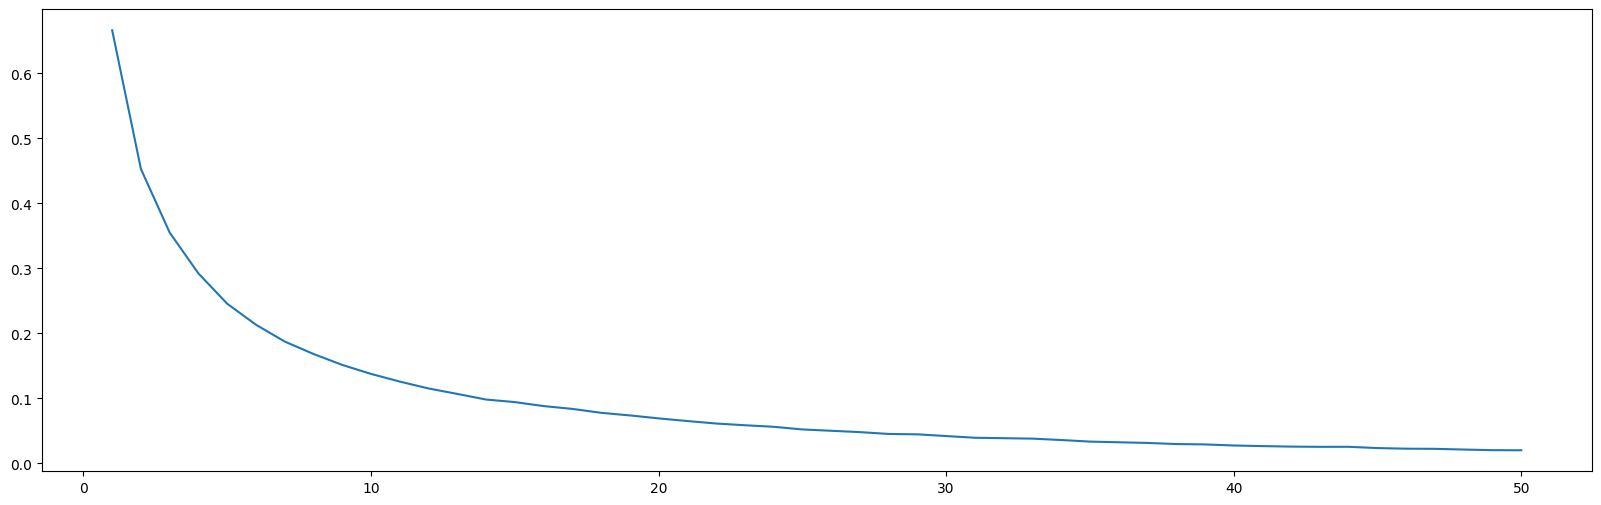

In [14]:
torch.manual_seed(1337)
        

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

        # number of nodes (neurons) in input, hidden, and output layer
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.drop = torch.nn.Dropout(p=0.2)
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.ELU()
        self.batchnorm = torch.nn.BatchNorm1d(hiddennodes)
        self.batchnorm2 = torch.nn.BatchNorm1d(outputnodes)

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.drop(out)
        out = self.batchnorm(out)
        out = self.who(out)
        out = self.activation(out)
        out = self.batchnorm2(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]


if __name__ == "__main__":

    total_losses = []
    
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.001
    # batch size
    batch_size = 300
    # number of epochs
    epochs = 50

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        losses = []
        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if batch_idx % 200 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        total_losses.append(sum(losses)/len(losses))
    ##### Testing! #####
    model.eval()
    test_loss = 0
    correct = 0
    with torch.inference_mode():
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            output = model(features)
            test_loss += criterion(output, target).item()  # sum up batch loss
            losses.append(criterion(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model.state_dict(), "mnist_005.pth")
    plt.figure(figsize=(20,6))
    plt.plot(range(1, epochs+1), total_losses)
    plt.savefig("fifth.png")

# Висновки

З останнім експерементом стало відомо:

- Епохи мають бути в межах 30-100, тоді досягаються найкращі результати
- Оптимізатор - Адам із стандартним для нього льорнінг рейтом
- Батч сайз 200-400 оптимальний для якісного та швидкого навчання
- Оптимальна послідовність слою: активація, дропаут, батч нормалізація
- ELU найбільш підходить як функція активації
- Два слої достатньо

З такими параметрами ми зменшили похибку у 70 разів та збільшили точність моделі на 2% (приблизно на 250 правильних відповідей більше)

Саме цю модель збережено до файлу